In [174]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [217]:
def build_basin(m, n, Amp, phi, N, beta, L):
    ''' gives back the non-normalised n/m basin mode at phase phi. m and n are the zonal and meridional wavenumbers respectively, and N the number of grid points.'''
    
    X = np.linspace(0, L, N)
    Y = np.linspace(0, L, N)
    x, y = np.meshgrid(X, Y)
    
    lam = 2*np.pi*np.sqrt(n**2 + m**2)
    sigma = beta*L/(2*np.pi*np.sqrt(n**2+m**2))
    
    # Psi interior
    pi = np.pi
    psi = Amp*np.cos(phi + (beta * x) / (2 * sigma)) * np.sin((m * pi * x) / L) * np.sin((n * pi * y) / L)
    
    # q interior
    
    q = -Amp*(
            (
                (beta**2 * L**2 + 4 * (m**2 + n**2) * pi**2 * sigma**2) * np.cos(phi + (beta * x) / (2 * sigma)) * np.sin((m * pi * x) / L) +
                4 * beta * L * m * pi * sigma * np.cos((m * pi * x) / L) * np.sin(phi + (beta * x) / (2 * sigma))
            ) * np.sin((n * pi * y) / L)
        ) / (4 * L**2 * sigma**2)
            
    return psi, q

In [218]:
def project_basin(q, m, n, L, norm = 0):
    ''' gives back complex amplitude that describes the projection of the field q onto the basin mode n,m. Projection on q gives the energy (in which case norm = 1 gives the proper normalisation), but works on any field.'''
    
    N  = np.shape(q)[-1]
    
    X = np.linspace(0, L, N)
    Y = np.linspace(0, L, N)
    x, y = np.meshgrid(X, Y)
    
    mode = np.exp(-1j*np.pi*np.sqrt(m**2 + n**2)*x/L)*np.sin(m*np.pi*x/L)*np.sin(n*np.pi*y/L)
    
    delta = L/(N-1)
    
    if norm:
        coeff_mn = (-np.pi**2*(n**2 +m**2)/4)*(mode*q).sum(axis = (-2,-1))*delta**2
    else:
        coeff_mn = (mode*q).sum(axis = (-2,-1))*delta**2
        
    return coeff_mn

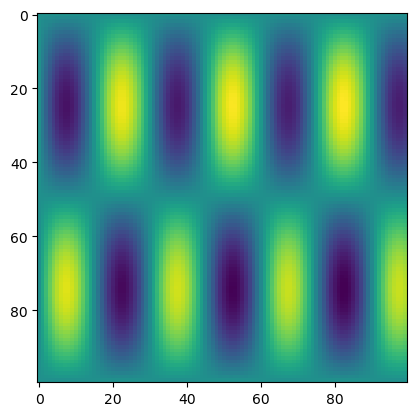

In [226]:
# Here I will show how to build a series of oscillating basin modes, project it, show energy equivalency, show the dispersion relation, and then how to reconstruct the wave field from this.

#parameters
N = 100
Nt = 100
L = 2.45e6
beta = 1.7e-11

# basin mode numbers
m = 3
n = 2

# set frequency and amplitude
sigma = beta*L/(2*np.pi*np.sqrt(m**2 + n**2))
Amp = 23.234

# say the time series represents one period
t = np.linspace(0,2*np.pi/sigma, Nt)
dt = 2*np.pi/sigma/(Nt-1)

x = np.linspace(0,L,N)
y = np.linspace(0,L,N)
delta = L/(N-1)

# vector for phase at each snapshot
phi = np.linspace(0,2*np.pi,Nt)

# create variable vectors
psi = np.zeros([Nt,N,N])
q = np.zeros([Nt,N,N])

for nt, phase in enumerate(phi):
    psi[nt,:,:], q[nt,:,:] = build_basin(m, n, Amp, phase, N, beta, L)
    
# plot example psi
plt.imshow(q[0,:,:])

Text(0.5, 0, 'time')

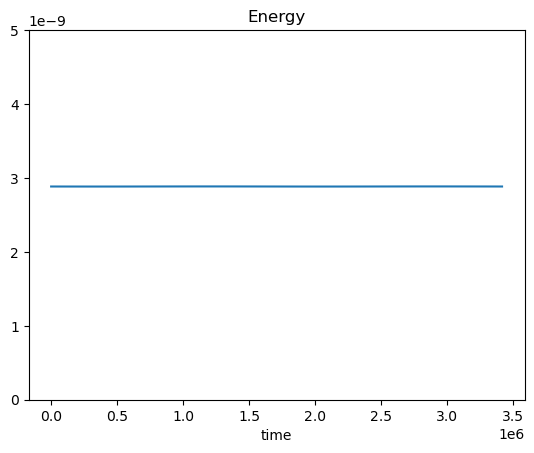

In [227]:
# calculate energy (noralized by domain size)

E = 1/L**2*np.sum(-psi*q, axis = (-2,-1))*delta**2

plt.plot(t,E)
plt.ylim([0,5e-9])
plt.title("Energy")
plt.xlabel("time")

# Energy is constant in time

Amplitude was set to  23.234


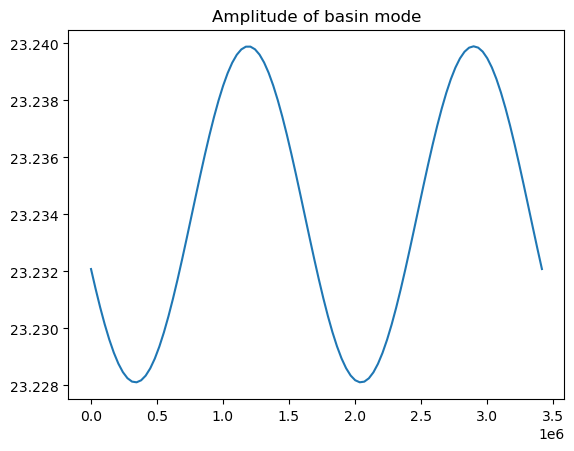

In [228]:
# project flow onto basin modes

psi_mn = np.zeros(Nt, dtype = complex)

for nt in range(Nt):
    psi_mn[nt] = project_basin(q[nt,:,:], m, n, L, norm = 0)

# We renormalize the energy to obtain ampltitudes (see overleaf)

psi_mn /= -np.pi**2*(m**2 + n**2)/4

plt.plot(t, abs(psi_mn))
plt.title("Amplitude of basin mode")
#plt.ylim([0,Amp+2])

print("Amplitude was set to ", Amp)

Total Energy is 2.884686014787376e-09


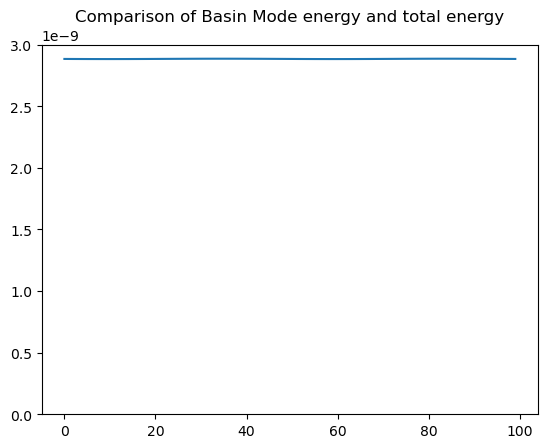

In [233]:
# in order to calculate energy from the amplitudes we need to multiply by the renormalization factor. (sort of like the factor of k**2 + l**2 in the energy of the spectral budget)

E_basin = np.pi**2*(m**2 + n**2)/4*np.abs(psi_mn)**2/L**2

plt.plot(E_basin)
plt.title("Comparison of Basin Mode energy and total energy")
plt.ylim([0,3e-9])

print("Total Energy is", np.mean(E))

# basin mode energy is the same as the total energy --> Parseval's identity should hold.

In [234]:
# now we calculate the wave pulsation, using the same formula as for the spectral code
dpsi_mn_dt = (psi_mn[2:] - psi_mn[:-2])/(2*dt)

pulsation_observed = np.imag(np.conj(psi_mn[1:-1])*dpsi_mn_dt)/np.abs(psi_mn[1:-1])**2

sigma =  1.8384992677505043e-06


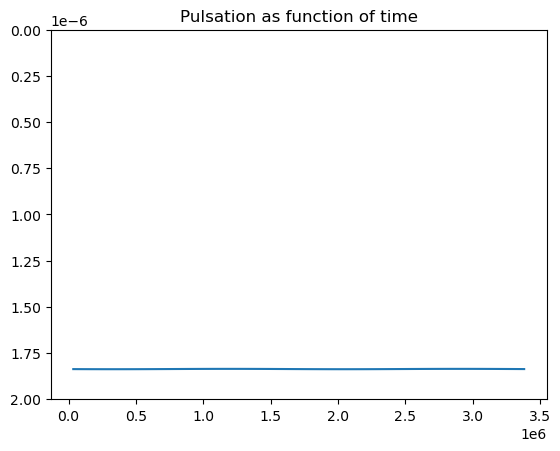

In [235]:
plt.plot(t[1:-1], pulsation_observed)
plt.ylim([2e-6,0])
plt.title("Pulsation as function of time")

# Agrees well with basin mode frequency we used to create the time series
print("sigma = ", sigma)